In [188]:
import numpy as np 
import pandas as pd 
from keras.models import Sequential,load_model
from keras.layers import LSTM,Dense,Activation
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pickle
from keras import Model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [189]:
pickle_in = open('GOOGL_data_from_quandl.pickle','rb')
df = pickle.load(pickle_in)
df['Close_10MA'] = df['Adj. Close'].rolling(window=10).mean()
df['Volume_10SUM'] = df['Adj. Volume'].rolling(window=10).sum()

In [190]:
df['target']= df['Adj. Close'].shift(-1)  #預測幾天後的close
df.dropna(inplace=True)
df_pre = df[['Close_10MA']]

In [191]:
scaler = StandardScaler()
X = np.array(df_pre)
y = np.array(df['target'])
X = scaler.fit_transform(X)  #標準化

In [192]:
track_back = 1  #以過去多少天的時間序列來訓練
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)
#train_adjust_size=X_train.shape[0] % track_back
#X_train = X_train[:-train_adjust_size]
#y_train = y_train[:-train_adjust_size]
#test_adjust_size=X_test.shape[0] % track_back
#X_test = X_test[test_adjust_size:]
#y_test = y_test[test_adjust_size:]
features=X_train.shape[1]

In [193]:
X_train = np.reshape(X_train, (int(X_train.shape[0]/track_back), track_back, X_train.shape[1]))
y_train = np.reshape(y_train, (int(y_train.shape[0]/track_back), track_back))
X_test = np.reshape(X_test, (int(X_test.shape[0]/track_back), track_back, X_test.shape[1]))
y_test = np.reshape(y_test, (int(y_test.shape[0]/track_back), track_back))

In [205]:
model = Sequential()
model.add(LSTM(units=400,input_shape=(track_back,features),return_sequences=True))
model.add(LSTM(units=400))
model.add(Dense(units =track_back))
model.add(Activation('relu'))
model.compile(optimizer='adam',loss='mae')

In [206]:
model.fit(X_train, y_train, epochs = 20, batch_size =10,shuffle=True,validation_data=(X_test,y_test))

Train on 2731 samples, validate on 683 samples
Epoch 1/20
2731/2731 [==============================] - 12s 4ms/step - loss: 345.2566 - val_loss: 271.9541
Epoch 2/20
2731/2731 [==============================] - 8s 3ms/step - loss: 246.9266 - val_loss: 214.4291
Epoch 3/20
2731/2731 [==============================] - 8s 3ms/step - loss: 207.3711 - val_loss: 194.2215
Epoch 4/20
2731/2731 [==============================] - 8s 3ms/step - loss: 196.1505 - val_loss: 164.8683
Epoch 5/20
2731/2731 [==============================] - 8s 3ms/step - loss: 149.3151 - val_loss: 127.6445
Epoch 6/20
2731/2731 [==============================] - 10s 4ms/step - loss: 124.9151 - val_loss: 107.3165
Epoch 7/20
2731/2731 [==============================] - 12s 4ms/step - loss: 104.3869 - val_loss: 88.8478
Epoch 8/20
2731/2731 [==============================] - 9s 3ms/step - loss: 86.2398 - val_loss: 71.3088
Epoch 9/20
2731/2731 [==============================] - 9s 3ms/step - loss: 69.9862 - val_loss: 59.0377
E

In [180]:
model.save('model_data.h5')

In [181]:
model=load_model('model_data.h5')

In [207]:
pretest=np.array(df_pre['Close_10MA'])
pretest = np.reshape(pretest,(pretest.shape[0],1))

In [208]:
pretest = scaler.fit_transform(pretest)
pretest = np.array([[i] for i in pretest])
predict_result=model.predict(pretest)

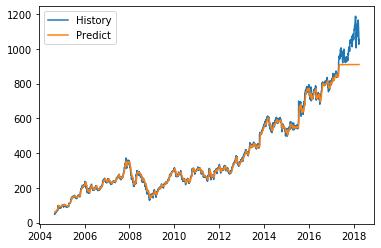

In [209]:
df['Predict_result'] = predict_result[:]
df['Predict_result']=df['Predict_result'].shift(1) #因為是預測未來
plt.plot(df['Adj. Close'],label='History')
plt.plot(df['Predict_result'],label='Predict')
plt.legend()